<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.S50x Course Team, Copyright 2021 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# LECTURE 4

In this class, we are going to understand what uncertainty is, and how uncertainty is obtained. For this lecture, we will focus on data from the Auger Experiment. The Auger experiment measures high energy cosmic rays. [Here](https://www.dropbox.com/s/t8mdotc11mdrmwx/PCH_Lecture4_8S50.pdf?dl=0) are some slides describing the Auger Experiment. 

<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 4.0 Overview of Learning Objectives

In this lecture we will explore the following objectives:

- What are fit residuals?
- Extracting the fit uncertainty on parameters
- Likelihood
- Interpreting Likelihood
- Getting things to fit: Chi-by-eye and More

<br>
<!--end-block-->

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

!--start-block-->
<hr style="height: 1px;">

## 4.1  What are Fit Residuals? 

In the last class, we fit the supernovae data, and got a pretty good fit for Hubble's parameter. However, we didn't really try to understand how good our fit was, nor did we try to extract an uncertainty on the parameters. To understand what is going on, let's at least look at our previous fit and try to understand residuals. Let's first look at the supernovae data. 

<br>
<!--end-block-->

In [2]:
import numpy as np
import csv
import math
#Lets try to understand how good the fits we made in last class are, lets load the supernova data again
label='../Lecture3/sn_z_mu_dmu_plow_union2.1.txt'
def distanceconv(iMu):
    power=iMu/5+1
    return 10**power

def distanceconverr(iMu,iMuErr):
    power=iMu/5+1
    const=math.log(10)/5.
    return const*(10**power)*iMuErr

#Now lets zoom in on the small redshift data
def load(iLabel,iZMax):
    redshift=np.array([])
    distance=np.array([])
    distance_err=np.array([])
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter='\t')
        for row in plots:
            if float(row[1]) > iZMax:
                continue
            redshift = np.append(redshift,float(row[1]))
            distance = np.append(distance,distanceconv(float(row[2])))
            distance_err = np.append(distance_err,distanceconverr(float(row[2]),float(row[3])))
    return redshift,distance,distance_err

redshift=np.array([])
distance=np.array([])
distance_err=np.array([])
redshift,distance,distance_err = load(label,0.1)

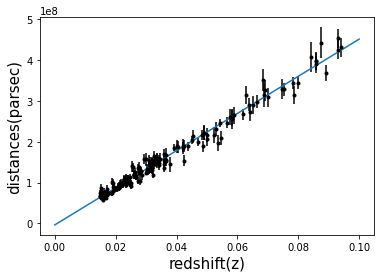

Hubbles Constant: 65.87381819553848 intercept -3931446.778206587


In [3]:
import matplotlib.pyplot as plt


#Now lets run the regression again
#Lets run the regression again
def variance(isamples):
    mean=isamples.mean()
    n=len(isamples)
    tot=0
    for pVal in isamples:
        tot+=(pVal-mean)**2
    return tot/n

def covariance(ixs,iys):
    meanx=ixs.mean()
    meany=iys.mean()
    n=len(ixs)
    tot=0
    for i0 in range(len(ixs)):
        tot+=(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/n

def linear(ix,ia,ib):
    return ia*ix+ib

def regress(redshift,distance):
    #Lets regress
    var=variance(redshift)
    cov=covariance(redshift,distance)
    A=cov/var
    b=distance.mean()-A*redshift.mean()
    #Done!
    return A,b

def plotAll(redshift,distance,distance_err,A,b):
    #now lets plot it
    xvals = np.linspace(0,0.1,100)
    yvals = []
    for pX in xvals:
        yvals.append(linear(pX,A,b))

    #Plot the line
    plt.plot(xvals,yvals)
    plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
    plt.xlabel('redshift(z)', fontsize=15) #Label x
    plt.ylabel('distances(parsec)', fontsize=15)#Label y
    plt.show()
    #Print it out
    print("Hubbles Constant:",1e6*3e5/A,"intercept",b)#Note 1e6 is from pc to Mpc and 3e5 is c in km/s

A,b=regress(redshift,distance)
plotAll(redshift,distance,distance_err,A,b)

Now that we have loaded and fit the data again, we would like to actually understand how good the fit is. To do that, we are going to define the residual in $y$. We can define this as 
\begin{equation}
y^{resid}_{i} = f(x_{i})-y_{\rm true} = \hat{y}_{i}-y_{\rm true}
\end{equation}
Alternatively, we could also divide the above by the uncertainty $\sigma$. For now, let's compute it for this data, and make a histogram.

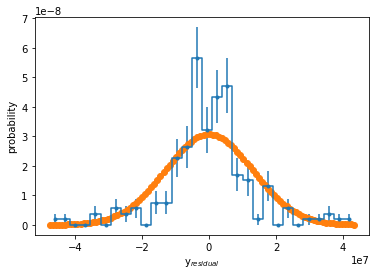

In [4]:
from scipy import stats

def residual(func,args,distance,distance_err=[]):
    residuals=np.array([])
    for i0 in range(len(redshift)):
        pResid=func(redshift[i0],args[0],args[1])-distance[i0]
        if len(distance_err) > 0:      
            pResid=pResid/distance_err[i0]
        residuals = np.append(residuals,pResid)
    return residuals

#This time we are going to look at a histogram of the residuals
def plotHist(residuals):
    y0, bin_edges = np.histogram(residuals, bins=30)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    norm0=len(residuals)*(bin_edges[-1]-bin_edges[0])/30.
    plt.errorbar(bin_centers,y0/norm0,yerr=y0**0.5/norm0,marker='.',drawstyle = 'steps-mid')
    
    #for good measure, lets compare this to a gaussian distribution
    k=np.linspace(bin_edges[0],bin_edges[-1],100)
    normal=stats.norm.pdf(k,0,residuals.std())
    plt.plot(k,normal,'o-')
    plt.xlabel("y$_{residual}$")
    plt.ylabel("probability")
    plt.show()
residuals=residual(linear,[A,b],distance)
plotHist(residuals)

So you can see our residual distribution looks like a normal(Gaussian) distribution. Again here is the analytic form of the normal distribution. 
\begin{equation}
N(x,\mu,\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}

It has the very important properties, that you can derive yourselves: 
\begin{equation}
E[N(x,\mu,\sigma]=\mu \\
V[N(x,\mu,\sigma]=\sigma^2 \\
\end{equation}

Now recall from previous lectures that the sum of random numbers converges to a Gaussian in the large $N$ limit. That means that any random set of distributions should be approximately Gaussian. This is a very powerful statement, that we will use again and again.  

### Challenge question
Make the above residual distribution, but now divide by the uncertainty. Yielding the formula

\begin{equation}
y^{resid}_{i} = \frac{f(x_{i})-y_{true}}{\sigma_{y}}
\end{equation}

If we plot this, and it is truly Gaussian what should be the shape and RMS of this distribution? 

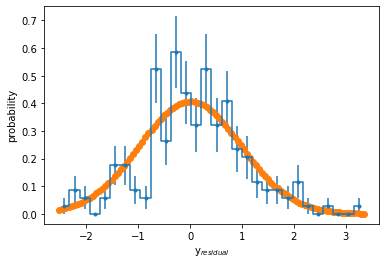

Ideally we should have a Gaussian with mean(residuals)=0 Instead we have 0.0674380962700456
Ideally we should have a Gaussian with std(residuals)=1. Instead we have 0.9807770453234462


In [5]:
residuals=residual(linear,[A,b],distance,distance_err)
plotHist(residuals)
print("Ideally we should have a Gaussian with mean(residuals)=0 Instead we have",residuals.mean())
print("Ideally we should have a Gaussian with std(residuals)=1. Instead we have",residuals.std())
hide_toggle()

From the above exercise, we see that the residuals are very close to a perfect gaussian distribtuion. This means that our uncertainties are very well measured. Its not always the case that this is true. Often experimentalists will over inflate their uncertainties yielding the scenario where the standard deviation is significantly less than $1$ since $\sigma$ is too large. 

## 4.2 Extracting uncertainty for a linear fit

Now, given the residuals above for our fit, we would like to come up with a way to get the variance of the parameters $A$ and the parameter $b$. For the case of a linear regression, we actually do this with a little bit of math. To do this, I would like to define two new defintions. First, I would like to define the residual sum of squares, often referred to as the RSS. It is defined as 

\begin{eqnarray}
\rm{RSS} & = & \sum_{i=1}^{N} \left(y_{i} - f\left(x_{i})\right) \right)^2
         & = & \sum_{i=1}^{N} \left(y_{i} - Ax_{i}-b \right)^2
\end{eqnarray}

Furthermore, we can define the mean squared error($\hat{\sigma}_{\rm{MSE}}$) as the average of the RSS. 
\begin{eqnarray}
\hat{\sigma}_{\rm{MSE}} & = & \frac{1}{N-2}\sum_{i=1}^{N} \left(y_{i} - f\left(x_{i})\right) \right)^2
                        & = & \frac{1}{N-2}\sum_{i=1}^{N} \left(y_{i} - Ax_{i}-b \right)^2
\end{eqnarray}
Now, we don't divide by $N$ because of the fact that $A$ and $b$ are determined from the data, and thus are actually not free parameters, thus removing 2-degrees of freedom in the data. To understand this imagine what $\hat{\sigma}_{\rm{MSE}}$  would be if you fit 2 points (0) since the line $f(x)$ would just connect the two points, so in fact there are no degrees of freedom of variance. A third point would thus fluctuate about the line with an MSE consistent of one point fluctions. 

Now we want to compute the variance of A. To understand the variance calculation, we need to consider, which variables are random and which variables are not random. In a linear regression, we try to solve for $f(x_{i})$ with the implication it cannot predict $y_{i}$ perfectly. However, $x_{i}$ are defined in this construction to be fixed, true numbers. As a consequence, we can consider $y_{i}$ the one true random variable, with a variance defined as $\rm{RSS}$. 

To get the variance on $A$ we can use the variance in $y_{i}$. The way to think about this is that $y_{i}=\hat{y}_{i}+u_{i}$ where $u_{i}$ is a random variable defining the variation of $y_{i}$ in the observed result. 

Now, let's go back to the definition of $A$

\begin{eqnarray}
   A & = &  \frac{\frac{1}{N} \sum_{i=1}^{N} \left(x_{i}-\bar{x}\right) \left(y_{i}-\bar{y}\right)}{\frac{1}{N} \sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2} \\
     & = & \sum_{i=1}^{N}  \frac{\left(x_{i}-\bar{x}\right)}{\sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2}   \left(y_{i}-\bar{y}\right)\\
     & = & \sum_{i=1}^{N}  w_{i} \left(y_{i}-\bar{y}\right)
\end{eqnarray}   

Where we have thrown the first bit into a weight $w_{i}$. Now, lets computing the variance of this. 
Now noting that $\mathrm{Var}(\bar{y})=0$ since $\bar{y}$ is a single number, we have that if we take take the varaince of above, it will just be proportional to the variance of the one number $y_{i}$ about its prediction $\hat{y}_{i}$. 

Noting that on average, we can write $\mathrm{Var}(y)=\left(y_{i}-\hat{y}_{i}\right)^2$, we can write the following relation for the variation of $A$ as a weighted sum of the variance in $y$. 
\begin{eqnarray}
  \rm{Var}(A) & = & \sum_{i=1}^{N}  w^{2}_{i} \left(y_{i}-\hat{y_{i}}\right)^2 \\
              & = & \sum_{i=1}^{N}  w^{2}_{i} \rm{Var}(y) \\
              & = & \sum_{i=1}^{N}  \left(\frac{\left(x_{i}-\bar{x}\right)}{\sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2}\right)^2 \rm{Var}(y) \\
              & = & \frac{\sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2}{\left(\sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2\right)^2} \rm{Var}(y) \\
              & = & \frac{1}{\left(\sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2\right)} \rm{Var}(y) \\
              & = & \frac{1}{N\rm{Var}(x)} \rm{Var}(y) \\
              & \rightarrow & \frac{1}{N-2}\frac{\rm{Var}(y)}{\rm{Var}(x)} 
\end{eqnarray}
Where in the last step, we have reduced $N\rightarrow N-2$ to account for the fact that $A$ and $b$ are determined from the fit. We can then write the variance of $b$ noting:
\begin{eqnarray}
b           & = & \bar{y} - A\bar{x} \\ 
\rm{Var}(b) & = & \rm{Var}(\bar{y}) + \rm{Var}(A)\bar{x}^2 \\
            & = & \frac{1}{N} \rm{Var}(y) + \rm{Var}(A)\bar{x}^2  
\end{eqnarray}
Recall here that $\bar{x}$ is not a random variable and so has no variance. Let's now calculate the uncertainties on $A$ and $b$. 

In [6]:
residuals=residual(linear,[A,b],distance)
VarY=np.sum(residuals**2)/(len(redshift)-2)
VarA=VarY/variance(redshift)/(len(redshift))
Varb=VarA*(redshift.mean())**2+VarY/len(redshift)
print("Hubbles Constant:",1e6*3e5/A,"+/-",1e6*3e5*math.sqrt(VarA)/A/A,"intercept",b,"+/-",math.sqrt(Varb))#Note 1e6 is from pc to Mpc and 3e5 is c in km/s


Hubbles Constant: 65.87381819553848 +/- 0.722443335496389 intercept -3931446.778206587 +/- 2047227.7501262664


Finally, we can write the weighted regression uncertainties. We will skip the full derivation and write the answer. The best fit parameters for the weighted regression are
\begin{eqnarray}
 \bar{y}_{w} & = & \frac{\sum_{i=1}^{N} \frac{y_{i}}{\sigma_{i}^2}}{\sum_{i=1}^{N} \frac{1}{\sigma_{i}^{2}} } \\
 \bar{x}_{w} & = & \frac{\sum_{i=1}^{N} \frac{x_{i}}{\sigma_{i}^2}}{\sum_{i=1}^{N} \frac{1}{\sigma_{i}^{2}} } \\
 A           & = &  \frac{\frac{1}{N} \sum_{i=1}^{N} \frac{1}{\sigma_{i}^{2}}\left(x_{i}-\bar{x}_{w}\right) \left(y_{i}-\bar{y}_{w}\right)}{\frac{1}{N} \sum_{i=1}^{N} \frac{1}{\sigma_{i}^{2}} \left(x_{i}-\bar{x}_{w}\right)^2} \\
b            & = & \bar{y}_{w} - A\bar{x}_{w}
\end{eqnarray}

and the variance for these parameters can be written below as
\begin{eqnarray}
  \sigma^{2}     & = & \frac{1}{N-2}\sum_{i=1}^{N} \frac{1}{\sigma_{i}^{2}} \left(y_{i} - Ax_{i}-b\right)^2 \\
  \sigma^{2}_{A} & = & \frac{\sigma^{2}}{\sum_{i=1}^{N}\frac{1}{\sigma_{i}^{2}} \left(x_{i}-\bar{x}_{w}\right)^2} \\
  \sigma^{2}_{b} & = & \left(\frac{1}{\sum_{i=1}^{N}\frac{1}{\sigma_{i}^{2}}}+\frac{\bar{x}^2_w}{\sum_{i=1}^{N}\frac{1}{\sigma_{i}^{2}}\left(x-\bar{x}_{w}\right)^2}\right)\sigma^2
\end{eqnarray}
They is very much parallel the variances of the parameters except now we have weighted the various events to reflect their respective weight in the measurement. Lets see how our weighte best fit result changes the value of Hubble's constant. 

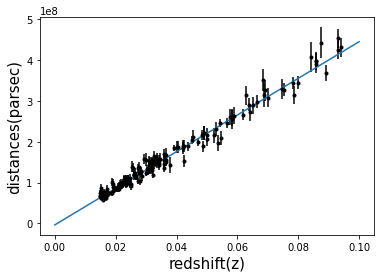

Hubbles Constant: 66.84173202572255 intercept -3501821.361192003
Weighted Hubbles Constant: 66.84173202572255 +/- 0.8288757665518472 intercept -3501821.361192003 +/- 1587583.9847322337
Hubbles Constant: 65.87381819553848 +/- 0.805044201721133 intercept -3931446.778206587 +/- 1587583.9847322337


In [8]:
weights=np.array([])
for pVal in distance_err:
    weights = np.append(weights,1./pVal/pVal)

#Now lets do it with weights
def variance_w(isamples,iweights):
    mean=np.average(isamples,weights=iweights)
    sumw=np.sum(iweights)
    tot=0
    for i0 in range(len(isamples)):
        tot+=iweights[i0]*(isamples[i0]-mean)**2
    return tot/sumw

def covariance_w(ixs,iys,iweights):
    meanx=np.average(ixs,weights=iweights)
    meany=np.average(iys,weights=iweights)
    sumw=np.sum(iweights)
    tot=0
    for i0 in range(len(ixs)):
        tot+=iweights[i0]*(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/sumw

def regress_w(redshift,weights,distance):
    varw=variance_w(redshift,weights)
    covw=covariance_w(redshift,distance,weights)
    Aw=covw/varw
    bw=np.average(distance,weights=weights)-Aw*np.average(redshift,weights=weights)
    return Aw,bw

Aw,bw=regress_w(redshift,weights,distance)
plotAll(redshift,distance,distance_err,Aw,bw)

def resid_w(func,args,distance,weights):
    residualsw=np.array([])
    for i0 in range(len(redshift)):
        pResid=linear(redshift[i0],args[0],args[1])-distance[i0]
        residualsw = np.append(residualsw,weights[i0]*pResid**2)
    return residualsw

residualsw = resid_w(linear,[Aw,bw],distance,weights)
sumw=np.sum(weights)
rsw=np.average(redshift,weights=weights)
sigmaw=np.sum(residualsw)/(len(redshift)-2)
VarAw=sigmaw*1./variance_w(redshift,weights)*1./sumw
Varbw=VarAw*(rsw)**2+sigmaw/sumw
    
print("Weighted Hubbles Constant:",1e6*3e5/Aw,"+/-",1e6*3e5*math.sqrt(VarAw)/Aw/Aw,"intercept",bw,"+/-",math.sqrt(Varbw))#Note 1e6 is from pc to Mpc and 3e5 is c in km/s
#Now the previous
print("Hubbles Constant:",1e6*3e5/A,"+/-",1e6*3e5*math.sqrt(VarAw)/A/A,"intercept",b,"+/-",math.sqrt(Varbw))#Note 1e6 is from pc to Mpc and 3e5 is c in km/s


### Thinking question 

Why is the weighted Hubble's constant different from the unweighted. Are these variations consistent with each other? 

!--start-block-->
<hr style="height: 1px;">

## 4.3  Likelihood

It turns out that 40% of all people have a gene where their pee smells after eating asparagus. Lets say we have 100 people and we observe 56 people claim their pee smells. What is the probability that this will happen. 

From the binomial probability we can write this as
\begin{equation}
P(56\mathrm{~smell~}|p)=p^{56}(1-p)^{44}\frac{100!}{44!56!}
\end{equation}

We can flip this observation and then compute the probablity given this observed value, or in other word we vary the probability. This is what we refer to as the likelihood. For this question, this would be probability value that we have data that gives us 56 smellers. 
\begin{equation}
{\mathrm{The~Likelihood}}~P(p|\mathrm{data})=p^{56}(1-p)^{44}\frac{100!}{44!56!}
\end{equation}

The maximum likelihood estimator (MLE) is thus the maximum of the probability given the data and a model.  Let's compute the maximum likelihood of this setup. 
\begin{eqnarray}
 \mathrm{MLE~} P(\rm{data}|p)&=&\frac{d}{dp} \left(p^{56}(1-p)^{44}\frac{100!}{44!56!}\right) = 0 \\
                 &=& 56 \left( p^{55}(1-p)^{44}\right) -44 \left(p^{56}(1-p)^{43}\right) = 0 \\
                               &=& 56 \left(1-p\right) -44 \left(p\right) = 0 \\
              &=& 56 - 100 p = 0 \\
p             &=& \frac{56}{100}            
\end{eqnarray}
So the maximum likelihood differs from what we thought for our distribution. However in this scenario we are varying $p$ and not varying the actual decision. For completeness, we can also write the log likelihood. 
\begin{equation}
{\rm ~The~Log~Likelihood~} \log\left(P(\rm{data}|p)\right)= 56 \log p + 44 \log(1-p)+\log\left(\frac{100!}{44!56!}\right)
\end{equation}
We often write things in terms of $\log$ (which is base $e$) since probabilities can vary by large absolute values and $\log$ helps to mitigate the large variations. Also since $\log$ is positive-definite and we can construct a one-to-one mapping, minimizing $\log(f)$ equates to minimizing $f$. 

Lets consider a poisson process, what is the rate of having high energy cosmic rays appear on the earth per unit area. This is often known as the cosmic ray flux. Lets analyze data from the Auger experiment. 
https://www.auger.org/index.php/science/data
Before we go into the physics of cosmic rays, lets look at the data. We can envision cosmic data as a poisson process. Think of it as the question, what is the rate of particles of a certain energy appearing. Lets take a look at the data. 

For the data, we are going to make some cool plots in visual coodinates. Don't get too stressed about this, suffice it to say that we are just pulling in some libraries to change the coodinates and make a pretty plot. There is really nothing deeper than that going on. 

<br>
<!--end-block-->

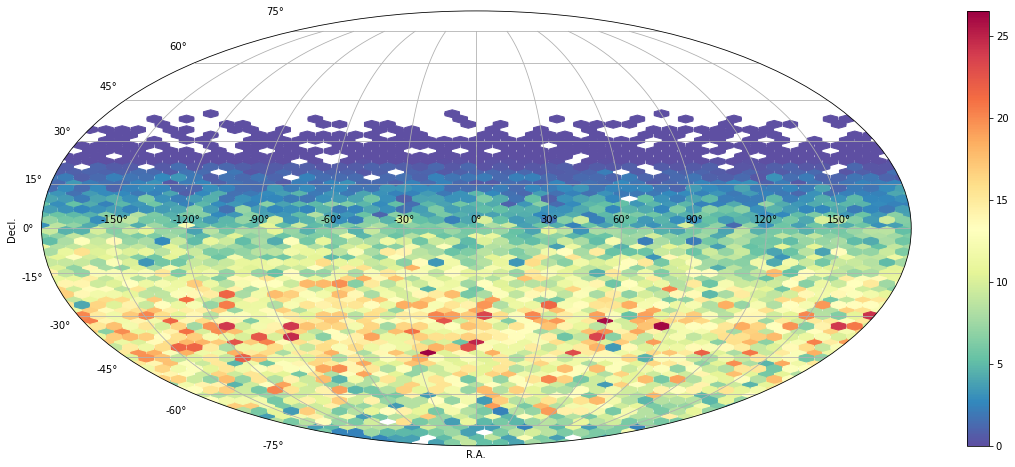

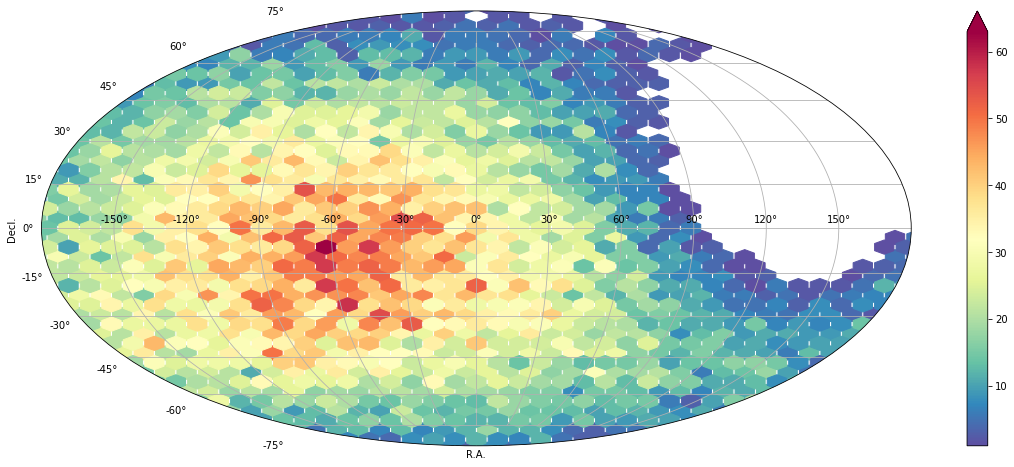

In [9]:
import numpy as np
import csv
import math
import matplotlib.pyplot as plt


#Lets say we have
label='events_a8_1space.dat'

def rad(iTheta):
    return iTheta/180. * math.pi

def rad1(iTheta):
    return iTheta/180. * math.pi-math.pi

def exposure(dec):
    theta_max = np.radians(60) # Maximum zenith angle in the dataset
    l = np.radians(-35.23) # Latitude of the center of the array (near Malargüe - Argentina)
    arg = (np.cos(theta_max) - np.sin(l)*np.sin(dec)) / (np.cos(l)*np.cos(dec))
    hm = np.arccos(arg.clip(-1, 1))
    return np.cos(l)*np.cos(dec)*np.sin(hm) + hm*np.sin(l)*np.sin(dec)

def load(label):
    dec=np.array([])
    ra=np.array([])
    az=np.array([])
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile,delimiter=' ')
        for pRow in plots:
            if '#' in pRow[0] or pRow[0]=='':
                continue
            dec = np.append(dec,rad(float(pRow[2])))
            ra  = np.append(ra,rad1(float(pRow[3])))
            az  = np.append(az,rad(float(pRow[4])))
    return dec,ra,az

dec,ra,az = load(label)
#Lets make a plot this is in local coordinates
color_map = plt.cm.Spectral_r
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(111, projection='mollweide')
w=exposure(dec) #correct for the exposure rate at the latitude of the observatory.
image = plt.hexbin(ra, dec, cmap=color_map,gridsize=60, mincnt=1,C=w,reduce_C_function=np.sum)
plt.xlabel('R.A.')
plt.ylabel('Decl.')
plt.colorbar()
plt.grid(True)
plt.show()

#Now lets plot this in Galactic Coordinates
from astropy.coordinates import SkyCoord
from astropy import units
from astropy.coordinates import Galactic

coords = SkyCoord(ra=ra, dec=dec, unit='rad')
rap = coords.galactic.l.wrap_at(180 * units.deg).radian
decp = coords.galactic.b.radian

color_map = plt.cm.Spectral_r
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(111, projection='mollweide')
image = plt.hexbin(rap, decp, cmap=color_map,gridsize=45, mincnt=1,reduce_C_function=np.sum)

plt.xlabel('R.A.')
plt.ylabel('Decl.')
plt.grid(True)
plt.colorbar(image, spacing='uniform', extend='max')
plt.show()

Now if you look at the above code, you will see one tricky piece of code, which is a correction for the exposure time. This is a latitude based correction aimed at correcting for the fact that most of the events will be seen at the latitude of the detector (at 34 degrees south), which is what you see when we plot the sky. One interesting thing that might not be clear however, is the fact that there is a  variation of the intensity as a function of  the RA. Lets zoom in on this variation and plot a histogram of it. 

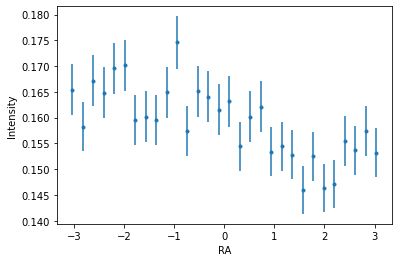

In [12]:
from scipy import stats

def plotHist(iData,iNBins=30):
    #Ok enough of having fun, lets look at the asymmetry we observe in right asecion
    y0, bin_edges = np.histogram(ra, bins=iNBins)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    norm0=len(ra)*(bin_edges[-1]-bin_edges[0])/iNBins
    plt.errorbar(bin_centers,y0/norm0,yerr=y0**0.5/norm0,marker='.',drawstyle = 'steps-mid',linestyle='none')
    plt.xlabel("RA")
    plt.ylabel("Intensity")
    plt.show()
    return bin_centers,y0

_,_ = plotHist(ra)

Now normally, there are some corrections to this distribution to account for various non-uniformities in angle of the detector. Note, that these non-uniformites are not so large in RA($\phi$) for the simple fact that the Earth rotates. So we will neglect these for this study. However, in reality you can correct for these by building a simulation. 

Ok, so even without corrections we see that negative RA has more events than positive RA. Let's zoom on this some more, and count the events. Recall that this is a poisson process, so the uncertainty on any number $N$ is given by $\sigma_{N}=\sqrt{N}$. 

NLeft: 16600 +/- 128.84098726725125 NRight: 15587 +/- 124.84790747145104 total/2 16093.5


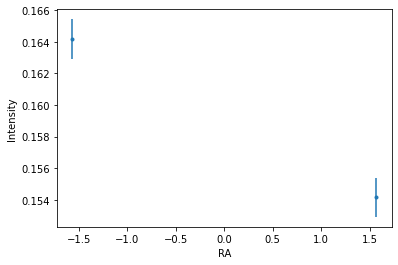

(array([-1.57079633,  1.57079633]), array([16600, 15587]))

In [13]:
#Lets say we have
NLeft=0
NRight=0
for i0 in range(len(ra)):
    if ra[i0] < 0:
        NLeft+=1
    else:
        NRight+=1
print("NLeft:",NLeft,"+/-",math.sqrt(NLeft),"NRight:",NRight,"+/-",math.sqrt(NRight),"total/2",len(ra)/2.)

plotHist(ra,2)

On the left had side we see nearly 16600 events over a period of 10 years of operation of Auger. If we take this as a rate, we have that $\lambda=np=16600$, which means that this process behaves as a poission process with maximum likelihood at $\lambda=16600$. To see this, lets write our a poisson distribution, we can imagine we have $N$ processes that have a probability of $1$ event in the time period the data was taken. The likelihood is just the probability of all $N$
\begin{equation}
\mathcal{L} = \frac{\lambda^{N}}{N!} e^{-\lambda}\\
\end{equation}
The log-likelihood of this distribution is just the log of this. 
\begin{equation}
\log(\mathcal{L})=N\log(\lambda)-\lambda-\log(N!) \\
\end{equation}
Minimizing this likelihood distribution, we have
\begin{equation}
\frac{d\mathcal{L}}{d\lambda}=0\\
\frac{N}{\lambda}-1=0\\
\lambda=N
\end{equation}
So the maximum likelihood for $\lambda$ is just the number of events we observe in the data. Hence we can use that for the aggregate or split distribution to deduce the deviation. Lets compute this by computing the p-value ratio of the most likely occurence of a poisson process, and the one actually observed. 

In [14]:
def pvalues(NLeft,NRight):
    #Lets compute it
    lamb=(NLeft+NRight)/2. #average nubmer of events
    pleft=stats.poisson.pmf(NLeft,lamb) #probability of left given averge
    pright=stats.poisson.pmf(NRight,lamb) #probability of right given averaged 
    pcheck=stats.poisson.pmf(int(lamb),lamb)#Most likely probability 
    print("Likelihood Ratio-left",pleft/pcheck,"Likelihood Ratio-right",pright/pcheck,"check",pcheck/pcheck)
pvalues(NLeft,NRight)

Likelihood Ratio-left 0.00036943129315803906 Likelihood Ratio-right 0.00032252051151133976 check 1.0


If we take the total number of events as the central value, and we predict the rate in right ascension to be uniform we have that $N_{tot}=16093.5$. In which case the likelihood for $N_{left}$ is $p=3\times10^{-4}$ less likely that than the central value. Likewise with the right. What about the lower energy data?

### Challenge question
Load the data at lower energy (4-8 EeV cosmic rays) '''events_a4_1space.dat''', plot the RA variation, and compute the asymetry. What is the significance of the variation? 

NLeft: 40843 +/- 202.0965115978007 NRight: 40858 +/- 202.13361917306088 total/2 40850.5
Likelihood Ratio-left 0.9994003979088298 Likelihood Ratio-right 0.9992170135352566 check 1.0


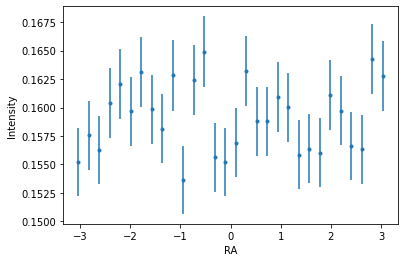

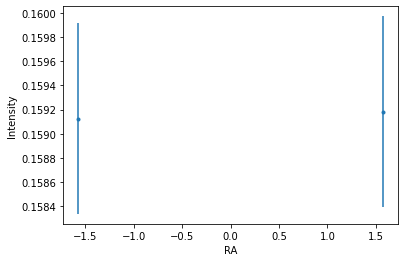

In [15]:
#Challenge question answer
label='events_a4_1space.dat'
dec,ra,az=load(label)

#compute asymmetry
NLeft=0
NRight=0
for i0 in range(len(ra)):
    if ra[i0] < 0:
        NLeft+=1
    else:
        NRight+=1
print("NLeft:",NLeft,"+/-",math.sqrt(NLeft),"NRight:",NRight,"+/-",math.sqrt(NRight),"total/2",len(ra)/2.)
pvalues(NLeft,NRight)

#plot it
plotHist(ra)
plotHist(ra,2)

hide_toggle()

## 4.4 Interpreting Likelihood

In the above, we compared the likelihood of two distributions from a flat hypothesis. We did this by considering the likelihood of a deviation from flat. We see that lower energy particles are pretty close to flat, where as higher energy particles start to deviate from flat. As a physicisist, this is when you start to think WTF. Let's talk about the physics implications later, but for now lets understand the statistics a little more. Let's ask a profound question. How can we improve the sensitivity of this measurement? 

**Use more than just the left and right sides of the distribution.**

In extending the sensivity, what we can do next is to define a likelihood for an arbitrary distribution. We can define the likelihood over a number of points by imagining that instead of just left and right, each bin is a specific measurement that we perform $N^{events}_{bin}$ times. From this, we can consider the probability of each bin given an expected mean prediction for that bin. For $N$ bins where for bin $i$ we have $x_{i}$ number of events and having the same mean prediction, we can write the likelihood as the multiplication of $N$ poission experiments each with the same predicted number of events. 
\begin{eqnarray}
\mathcal{L}(x|\lambda)&=&\prod_{i=1}^{N} p(x_{i}|\lambda) \\
\mathcal{L}(x|\lambda)&=&\prod_{i=1}^{N} \frac{\lambda^{x_{i}}}{x_{i}!}e^{-\lambda} \\
\log(\mathcal{L}(x|\lambda))&=&\sum_{i-1}^{N}  x_{i}\log(\lambda)-\log(x_{i}!)-\lambda
\end{eqnarray}
If we want to optmize this for a specific $\lambda$ then we just take the derivative
\begin{eqnarray}
\frac{d}{d\lambda}\log(\mathcal{L}(x|\lambda))&=&0=\sum_{i-1}^{N}  \frac{x_{i}}{\lambda}-1 \\
 N\lambda&=&\sum_{i-1}^{N} x_{i} \\
 \lambda=\bar{x}
\end{eqnarray}
Suprise, surprise! The optimval value $\lambda$ is just the average over all the bins.

Moreover, we can compute the variance of $\lambda$ from its definition. In this case we get 
\begin{equation}
\sigma_{\lambda}^2=\mathrm{Var}\left(\frac{1}{N}\sum_{i=1}^{N} x_{i}\right)\\
\sigma_{\lambda}^2=\frac{1}{N^2}\sum^{N}_{i=1}\mathrm{Var}(x_{i}) \\
\sigma_{\lambda}^2=\frac{1}{N^2}N\bar{x}=\frac{\bar{x}}{N}
\end{equation}

Lets compute the likelihood of the above distributions using all the bins.

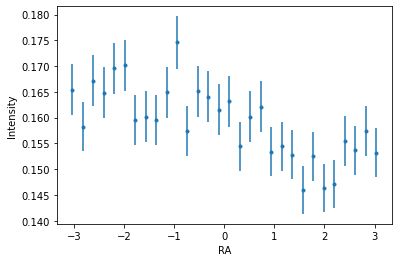

Log Likelihood 163.2082934483733 Regular Likelihood 7.593836555948741e+70
minimum found:      fun: 163.20829344839422
    nfev: 40
     nit: 15
 success: True
       x: 1072.9000267874344 Mean: 1072.9


/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/pharris/Library/Python/3.7/lib/python/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


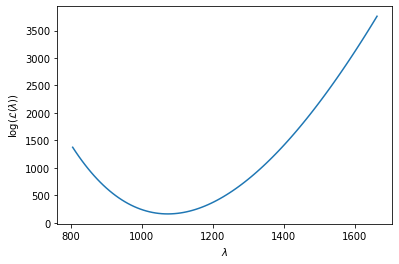

In [35]:
_,xis=plotHist(ra)

#Now lets define the log of a poisson distribution (see above)
def logpoisson(lamb): #x is our lambda and y0 is our data
    lTot=0
    for xi in xis:
        test = math.factorial(xi)
        lTot = xi*np.log(lamb) - lamb  - math.log(test) + lTot
    return -1.*lTot

#Now lets take the mean of this distribution and compute labmda
lamb=xis.mean()
print("Log Likelihood",logpoisson(lamb),"Regular Likelihood",np.exp(logpoisson(lamb)))
x = np.linspace(lamb*0.75, lamb*1.55, 100)
plt.xlabel("$\lambda$")
plt.ylabel("$\log(\mathcal{L}(\lambda))$")
plt.plot(x, logpoisson(x));

#finally lets compute the minimum of this distribution
from scipy import optimize as opt
sol=opt.minimize_scalar(logpoisson, method='Brent')
print("minimum found:",sol,"Mean:",lamb.mean())

By minimizing the likelihood we are finding the optimum position of our parameters. One thing to note is that now we see that the liklelihood is some giant number, but the log likelihood is not large. The reason just results from the fact that we are multiplying a lot of small probability numbers.  

Now, lets go back to our test. We would like to test this variation and see if each bin is consistent with a poisson distribtuion. For this to be the case, our absolute likelihood value has to be a reasonable number. So what is a reasonable number?

Here is where we have to rely on some clever trickery. What we are going to do is invoke the central limit theorem, and state that since we are dealing with large numbers the distribution of our sample about its expectation is going to be gaussian with standard devation given by a poission distribution. Then, we can compute the log-likelihood. Let's do it for each of our bins. 

\begin{eqnarray}
\mathcal{L}(x|\lambda)&=&\prod_{i=1}^{N} p(x_{i}|\lambda) \\
\mathcal{L}(x|\lambda)&=&\prod_{i=1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x_{i}-\mu)^2}{2\sigma^2}} \\
-\log(\mathcal{L}(x|\lambda))&=&\sum_{i-1}^{N}  -\frac{1}{2}\log(2\pi\sigma^2)+\frac{(x_{i}-\mu)^2}{2\sigma^2}\\
\end{eqnarray}
The above is for $N$ gaussian distributed bins. For $N$ Poisson distributed bins we have approximating it as a gaussian with mean $\lambda$ and $\sigma=\lambda$, we can write
\begin{eqnarray}
\mathcal{L}(x|\lambda)&=&\Pi_{i=1}^{N} \frac{1}{\sqrt{2\pi\lambda}}e^{\frac{-(x_{i}-\lambda)^2}{2\lambda}} \\
-\log(\mathcal{L}(x|\lambda))&=&\sum_{i-1}^{N}  -\frac{1}{2}\log(2\pi\lambda)+\frac{(x_{i}-\lambda)^2}{2\lambda}\\
\end{eqnarray}
Recall from above using the Poisson form we had
\begin{eqnarray}
\log(\mathcal{L}(x|\lambda))&=&\sum_{i-1}^{N}  x_{i}\log(\lambda)-\log(x_{i}!)-\lambda
\end{eqnarray}

If we equate the two we see they are a bit different, and as a consequence our likelihood value will be different. Furthermore there is something else surprising and interesting about this. Let's look at just one term $N=1$ (not just for Poission).
\begin{eqnarray}
f(x|\lambda) &=&-\frac{1}{2}\log(2\pi\sigma^2)+\frac{(x_{i}-\mu)^2}{2\sigma^2}\\
E[f(x)]      &=&-\frac{1}{2}\log(2\pi\sigma^2)+E[g^{\prime}(x)]\\
\mathrm{where~}g^{\prime}(x)         &=&\frac{(x_{i}-\mu)^2}{2\sigma^2}\\
E[g^{\prime}(x)]      &=&\frac{\mathrm{Var}(x)}{2\sigma^2}\\
E[g^{\prime}(x)]      &=&\frac{\sigma^2}{2\sigma^2}=1/2\\
\end{eqnarray}

We have honed in on this one parameter $g^{\prime}(x)$ since the other parmeter is just a constant defined on the parameters of the gaussian distribution. Since we have assumed $x_{i}$ are each gaussian distributed with mean $\mu$ we get the expectation for this distribution is zero and the variance is $\sigma$, yielding 1/2 when considereding $g(x)$ over the data. As a consquence we have that $\log$ of the likelihood using a gaussian will be $\frac{1}{2}-\frac{1}{2}\log(2\pi\sigma^2)$. 

Since the 1st term doesn't affect the optimization it is often dropped. This gives us a much simpler optimization, which we multiply by 2 to make it look nice. 

\begin{eqnarray}
g(x) &=& \frac{(x_{i}-\mu)^2}{\sigma^2}\\
\end{eqnarray}
For variables, which are truly gaussian distributed we expect this to be 1. Furthermore if we sum over many of these variables we get: 
\begin{eqnarray}
g(x) &=& \sum_{i=1}^{N} \frac{(x_{i}-\mu)^2}{\sigma^2}\\
E[g(x)] & = & N
\end{eqnarray}
We then expect that for gaussian distributed variables this will give us a value of $N$. This expectation allows us to actually test the data. If we run over our data and compute $E[g(x)]$ and its too small ($\ll N$), then our value for $\sigma$ is too large. If our value for $E[g(x)]$ is too large ($\gg N$) then we don't have a good fit to the data and our value for $\sigma$ is too small. 

Furthermore, the sum of $N$ independent gaussian random numbers with variance 1 in itself makes its own distribution. This is a $\chi^{2}$ distribution with $N$ degrees of freedom, and $g(x)$ above is referred to as $\chi^{2}$. 

For a poission distribution, we can further simplify this to the classic $\chi^{2}$ that we physicists know and love and copiously use. 
 
\begin{eqnarray}
\chi^{2}(x) &=& \sum_{i=1}^{N} \frac{(x_{i}-\mu)^2}{\mu}\\
\end{eqnarray}

We are going to talk a lot more about $\chi^{2}$ distributions. However, an important think to note is that 
\begin{eqnarray}
E[\chi^{2}(x)] &\approx& N \\
E[\chi^{2}(x)/N] &\approx& 1 
\end{eqnarray}
This last relation is known as the normalized $\chi^{2}$, which we expect to approach $1$ in the large $N$ limit. This is often why fits report the normalized $\chi^{2}$. 

Let's now go back to our minimization problem. In the above code, we minimized the poission likelihood. Lets now minimize the gaussian likelihood, and the $\chi^{2}$ likelihood, and see what we get. 


Gaussian Likelihood at minimum -101.2777591712253 1072.9 30
chi2 value at minium 61.92441047627347


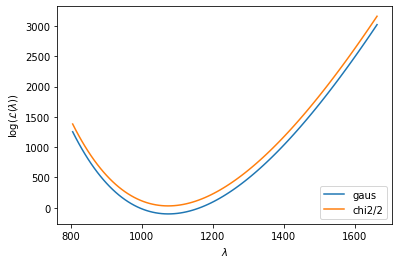

Gaussian Minimum 1072.9
Chi2 Minimum 1072.9


/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/pharris/Library/Python/3.7/lib/python/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


In [54]:
#Log likelihood of a gaussian distribution of our data from above
def loggaus(lamb):
    lTot=0
    for xi in xis:
        lTot = lTot+(0.5/(lamb+1e-5))*(xi-lamb)**2
        lTot = lTot-0.5*np.log(math.pi*2*lamb)
    return lTot
#chi2 distribution of our data from abve. 
def chi2(lamb):
    lTot=0
    for xi in xis:
        lTot = lTot+(1./(lamb+1e-10))*(xi-lamb)**2
    return lTot


lamb=xis.mean()
print("Gaussian Likelihood at minimum",loggaus(lamb),lamb,len(xis))
print("chi2 value at minium",chi2(lamb))

x = np.linspace(lamb*0.75, lamb*1.55, 100)
plt.plot(x, loggaus(x),label='gaus');
plt.plot(x, chi2(x)/2.,label='chi2/2');
plt.xlabel("$\lambda$")
plt.ylabel("$\log(\mathcal{L}(\lambda))$")
plt.legend(loc='lower right')
plt.show()

#Now lets minimize the two
from scipy import optimize as opt
sol1=opt.minimize_scalar(loggaus, method='Brent')
print("Gaussian Minimum",lamb.mean())
sol2=opt.minimize_scalar(chi2, method='Brent')
print("Chi2 Minimum",lamb.mean())

From the above, we see that we can get to the same minimum with either the full Gaussian or the $\chi^{2}$ distribution. Now understanding whether your fit is good or not can be completely interpreted by understanding the $\chi^{2}$ distribution. The $\chi^{2}$ is a very powerful distribution that we can compute numerically. We can use python tools to understand it, so lets do just that. 

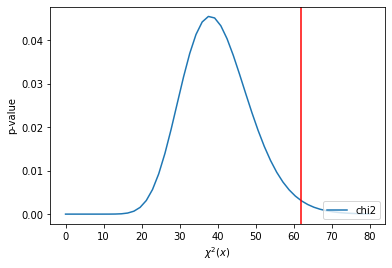

In [46]:
#Now lets look at our chi2 distribution and see how this compares
x = np.linspace(0,80)
chi2d=stats.chi2.pdf(x,40) # 40 bins
plt.plot(x,chi2d,label='chi2')
plt.axvline(chi2(lamb), c='red')
plt.legend(loc='lower right')
plt.xlabel("$\chi^{2}(x)$")
plt.ylabel("p-value")
plt.show()

For our above fit, we see that we have value we get for our $\chi^{2}$ calculation is 30, and we see that for a $\chi^{2}$ distribution that is a sum of 40 independent bins, we have that a value of 30 has a relatively large p-value in the sense that its close to the peak and we can see it on the blue line. We will talk more about how to interpret these values, but lets move forward with this. We can conclude though that a flat line, poissson-like hypothesis for this data is good. 

Now before we go to look at a bad fit, I want to go back to the variance of distribution. Above  we found $\sigma_{\lambda}^{2}=\frac{\bar{x}}{N}$. What if we can obtain this directly from our minimization?

With a little bit of math, that we will skip here we can compute:
\begin{equation}
\mathrm{Var}(\chi^{2}(x))=2N
\end{equation}


Which means that for $\Delta \chi^{2}(x)=|\chi^{2}(x)-\chi^{2}(x\pm\sqrt{2N})|$ we are within a standard deviation of the minimum. Imagine living on the line of htis distributionad and considering moving away from the minimum. Well, if we move away from the minimum our chances of having a distribution that has a $\chi^{2}$ value that is not exactly at the minimum is still quite likely provided we are in this $2N$ range. 

**Presuming that $\lambda$ is itself gaussian, we have that $\lambda$ also follows a $\chi^{2}$ distribution of the model.** A $\chi^{2}$ distribution is a sum of Gaussians, so 1 gaussian is still a $\chi^{2}$ distribution. 

Consequently $\Delta \chi^{2}$ varying our one paramter($\lambda$) corresponds to varying a $\chi^{2}$ distribution of 1-degree of freedom. This means that we can write
\begin{equation}
\rm{Var}(\chi^{2}_{1}) = 2 \\
\chi^{2}_{1}(X) = X^{2} = \left(\frac{x-\bar{x}}{\sigma}\right)^{2}\\
\rm{a~deviation~of~+1~in~X~corresponds~to}\\
\rm{\Delta \chi_{1}^2} = 2 \Delta \log \mathcal{L} = 1
\end{equation}
For 1 varying parameter (1 degree of freedom). What this means is that the variance on our measured value of $\lambda$ can be found by varying just the parameter $\lambda$ looking at the $\chi^{2}$ value and requiring that $\Delta \chi^{2}$ from the minimum be $1$. The position whtere it is 1 above and below the minimum correspond exactly to the $+1$ and $-1$ standard deviation of the value $\mu$. 

Let's dig a little deeper, to see this through a taylor expansion of $\chi^{2}$

\begin{equation}
\chi^{2}(x_{i},\mu)=\chi^{2}_{min}(x_{i},\mu_{0})+\frac{1}{2}\frac{\partial^{2}}{\partial \mu^{2}}\chi^{2}_{min}(x_{i},\mu_{0})(\lambda-\hat{\lambda})^{2}
\end{equation}
where $\hat{\lambda}$ is the best fit of $\lambda$ at the minimum. 

Now imagine we deviate up from the minimum of the $\chi^{2}$ by values $\sigma_{\mu}$, we know that these deviations need to correspond to $\frac{1}{2}$.  Since we can write out the full form with poisson uncertainty lets solve

\begin{eqnarray}
\mathrm{\Delta \chi^2}& = & 1 = \sum_{i=1}^N\frac{(\lambda-\hat{\lambda}+\sigma_{\lambda})^{2}}{\hat{\lambda}}-\sum_{i=1}^N\frac{(\lambda-\hat{\lambda})^{2}}{\hat{\lambda}}\\
1 & \approx & \sum_{i=1}^N\frac{(\lambda-\hat{\lambda}+\sigma_{\lambda})^{2}}{\hat{\lambda}}-\sum_{i=1}^N\frac{(\lambda-\hat{\lambda})^{2}}{\hat{\lambda}}\\
1 & = & \frac{1}{\hat{\lambda}}\sum_{i=1}^N (\lambda-\hat{\lambda}+\sigma_{\lambda})^{2}-(\lambda-\hat{\lambda})^{2}\\
1 & = & \frac{1}{\hat{\lambda}}\sum_{i=1}^N \sigma_{\lambda}^{2}+2\sigma_{\lambda}(\lambda-\hat{\lambda}) \\
1 & = & \frac{N\sigma_{\lambda}^{2}}{\hat{\lambda}} \\
\sigma_{\lambda}^{2} & = & \frac{\hat{\lambda}}{N}   \\
\end{eqnarray}
Just as in deriviation of $\sigma_{\lambda}^{2}$ above. This gives us a strong confirmation of the taylor expansion approach that we can verify emperically as well. Through this appraoch, we also immediately get the correspondance in the variaton of the $\chi^{2}$ that $\frac{\partial^{2} \chi^{2}}{\partial \theta^{2}}=\frac{2}{\sigma^2_{\theta}}$. This is known as Wilk's theoreme(https://www.jstor.org/stable/2957648?seq=1), and is related closely to a a more general form known as Wald's test. Its more generally written in terms of the likelihood as 
\begin{equation}
\sigma^{2}_{\theta} = \left(\frac{\partial^{2}\log \mathcal{L}}{\partial\theta^{2}}\right)^{-1}
\end{equation}


For multiple parameters, we write this as a vector $\vec{\theta_{i}}$, we can expand this in terms of the Hessian$\frac{\partial^{2}\chi^{2}}{\partial\theta_{i}\partial\theta_{j}}$, the taylor expansion is as follows
\begin{equation}
\chi^{2}(x_{i},\vec{\theta})=\chi^{2}_{min}(x_{i},\vec{\theta})+\frac{1}{2}(\theta_{i}-\theta_{j})^{T}\frac{\partial^{2}}{\partial \theta_{i}\theta_{0}}\chi^{2}_{min}(x_{i},\vec{\theta}_{0})(\theta_{j}-\theta_{0})
\end{equation}

Lets go back to our $\chi^{2}$ minimum function and compute the +1$\sigma$ variation and the -1$\sigma$ variations of the distribution. 

      converged: True
           flag: 'converged'
 function_calls: 17
     iterations: 16
           root: 1080.0202465349332
      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 1067.877233795037
sol1 1078.880245256955
sol2 1066.9197547430451


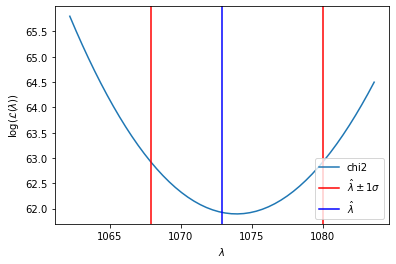

In [48]:
def chi2min(ilamb):
    minchi2=chi2(xis.mean())+1 #This is the minmum overe the data
    return chi2(ilamb)-minchi2

lamb=xis.mean()
sol1=opt.root_scalar(chi2min,bracket=[lamb, lamb*1.1],method='brentq')
sol2=opt.root_scalar(chi2min,bracket=[lamb*0.9, lamb],method='brentq')
print(sol1)
print(sol2)
print("sol1",xis.mean()+math.sqrt(xis.mean()/len(xis)))
print("sol2",xis.mean()-math.sqrt(xis.mean()/len(xis)))


minlog=chi2(lamb)
x = np.linspace(lamb*0.99, lamb*1.01, 50)
plt.plot(x, chi2(x),label='chi2');
plt.axvline(sol1.root, c='red',label="$\hat{\lambda}\pm1\sigma$")
plt.axvline(lamb, c='blue',label="$\hat{\lambda}$")
plt.axvline(sol2.root, c='red')
plt.legend(loc='lower right')
plt.xlabel("$\lambda$")
plt.ylabel("$\log(\mathcal{L}(\lambda))$")
plt.show()

### Challenging Challenge question? 

Now that we have computed a minimum $\chi^{2}$ and an uncertainty for the rate for the low energy data. What's the minimum, uncertainty, and $\chi^{2}$ value for the high energy data?

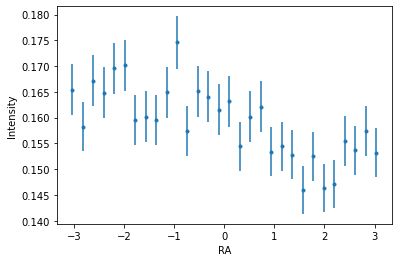

chi2 minmized value 1072.9


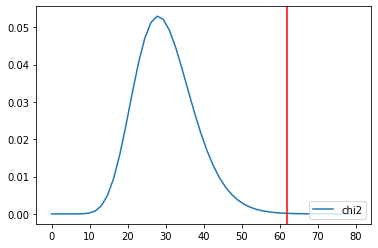

     fun: 61.8946550755921
    nfev: 39
     nit: 10
 success: True
       x: 1073.931577538073
      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 1080.0202465187633
      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 1067.877233830446
sol1 1078.880245256955
sol2 1066.9197547430451


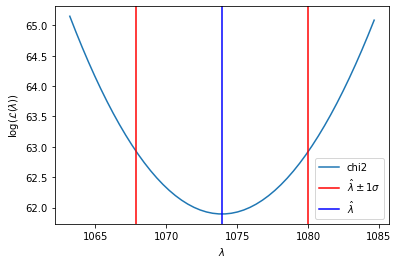

In [57]:
#solution
label8='events_a8_1space.dat'
dec,ra,az=load(label8)
nbins=30
_,xis=plotHist(ra,nbins)

#compute the mean over the bins
lamb=xis.mean()

#minimize it
sol2=opt.minimize_scalar(chi2, method='Brent')
print("chi2 minmized value",lamb.mean())

#Now lets look at our chi2 distribution and see how this compares
x = np.linspace(0,80)
chi2d=stats.chi2.pdf(x,nbins) # 40 bins
plt.plot(x,chi2d,label='chi2')
plt.axvline(chi2(lamb), c='red')
plt.legend(loc='lower right')
plt.show()

#now lets plot the mimum and uncertainty
sol0=opt.minimize_scalar(chi2, method='Brent')
lamb=sol0.x
sol1=opt.root_scalar(chi2min,bracket=[lamb, lamb*1.01],method='brentq')
sol2=opt.root_scalar(chi2min,bracket=[lamb*0.99, lamb],method='brentq')
print(sol0)
print(sol1)
print(sol2)
print("sol1",xis.mean()+math.sqrt(xis.mean()/len(xis)))
print("sol2",xis.mean()-math.sqrt(xis.mean()/len(xis)))

minlog=chi2(lamb)
x = np.linspace(lamb*0.99, lamb*1.01, 50)
plt.plot(x, chi2(x),label='chi2');
plt.axvline(sol1.root, c='red',label="$\hat{\lambda}\pm1\sigma$")
plt.axvline(lamb, c='blue',label="$\hat{\lambda}$")
plt.axvline(sol2.root, c='red')
plt.legend(loc='lower right')
plt.xlabel("$\lambda$")
plt.ylabel("$\log(\mathcal{L}(\lambda))$")
#plt.legend(loc='lower right')
plt.show()

hide_toggle()

## 4.5 Getting things to fit: Chi-by-eye and More

In reality all of this stuff can be seen just by looking at the plots by eye. Lets actually visualize all of what we just did with the high and low energy data. Just to be a bit lazy, we are going to do this with `lmfit`. 

In [59]:
import lmfit
#Plot a constant function
def f(x,a):
    return a

def prephist(iRA):
    y0, bin_edges = np.histogram(iRA, bins=30)
    x0 = 0.5*(bin_edges[1:] + bin_edges[:-1])
    y0 = y0.astype('float')
    return x0,y0,1./(y0**0.5)

def plothist(iRA):
    x,y,xweights=prephist(iRA)
    model  = lmfit.Model(f)
    p = model.make_params(a=1000)
    result = model.fit(data=y,x=x, params=p, weights=xweights)
    lmfit.report_fit(result)
    print(result.params.items(),result.params["a"].value)
    plt.errorbar(bin_centers,y,yerr=y**0.5,c='black',marker='.',linestyle = 'None')
    x = np.linspace(bin_edges[0],bin_edges[-1], 50)
    y=np.array([])
    for pX in x:
        pOut=f(pX,result.params["a"].value)
        y=np.append(y,pOut)
    plt.plot(x,y)
    plt.xlabel("RA")
    plt.ylabel("$N_{events}$")
    plt.show()
    
label8='events_a8_1space.dat'
dec,ra8,az=load(label8)
plothist(ra8)

label4='events_a4_1space.dat'
dec,ra4,az=load(label4)
plothist(ra4)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 30
    # variables        = 1
    chi-square         = 62.0646320
    reduced chi-square = 2.14015973
    Akaike info crit   = 23.8093674
    Bayesian info crit = 25.2105648
[[Variables]]
    a:  1070.83118 +/- 8.74023221 (0.82%) (init = 1000)
odict_items([('a', <Parameter 'a', value=1070.8311789292245 +/- 8.74, bounds=[-inf:inf]>)]) 1070.8311789292245


NameError: name 'bin_centers' is not defined

So you can see that all of our fitting actually did all of the computations we did before, except super quickly. Furthermore, we get the $\chi^{2}$ and the uncertainty. Lastly, and most importantly. We can do the chi-by-eye. You can see the top plot a lot fo the points don't cross the line whereas the bottom plot, a lot of the points DO cross the line. This is reflective in the fact that our chi2 is good for one and bad for other. 

### Challenge Question: 

How often should the points have uncertainties such that they not cross the line?

In [66]:
#Answer: 
print("Answer:",stats.norm.cdf(0,1)*100,"% Above the line")
print("Answer:",stats.norm.cdf(0,1)*100,"% Below the line")
hide_toggle()

Answer: 15.865525393145708 % Above the line
Answer: 15.865525393145708 % Below the line


We can define the "Chi-by-eye" test which states that **if the points mostly line up with the best fit then we are golden.**

Now, all the above math of the previous section actually holds in the scenario where we don't just fit a line. We could image every point is gaussian fluctuated about some predicted form. This means that our best fit function, we can make an assumption that the points are gaussian fluctuated about any function. Lets now try to see if we can fit the above function with a new form given by 
\begin{equation}
 f(x) = a + b \sin(x)
\end{equation}

[-3.0368729  -2.82743339 -2.61799388 -2.40855437 -2.19911486 -1.98967535
 -1.78023584 -1.57079633 -1.36135682 -1.15191731 -0.9424778  -0.73303829
 -0.52359878 -0.31415927 -0.10471976  0.10471976  0.31415927  0.52359878
  0.73303829  0.9424778   1.15191731  1.36135682  1.57079633  1.78023584
  1.98967535  2.19911486  2.40855437  2.61799388  2.82743339  3.0368729 ] [1115. 1067. 1127. 1111. 1143. 1147. 1076. 1080. 1076. 1112. 1177. 1061.
 1113. 1106. 1089. 1100. 1041. 1080. 1093. 1034. 1041. 1030.  984. 1028.
  986.  992. 1048. 1036. 1061. 1033.]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 30
    # variables        = 2
    chi-square         = 26.8040965
    reduced chi-square = 0.95728916
    Akaike info crit   = 0.62072051
    Bayesian info crit = 3.42311528
[[Variables]]
    a:  1072.00653 +/- 5.84870422 (0.55%) (init = 1000)
    b: -50.0226479 +/- 8.24221274 (16.48%) (init = 10)


<Figure size 432x288 with 0 Axes>

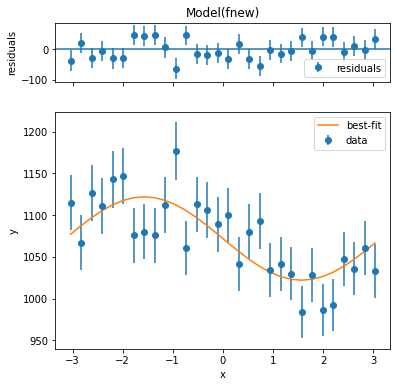

In [60]:
def fnew(x,a,b):
    pVal=b*np.sin(x)
    return a+pVal

label8='events_a8_1space.dat'
dec,ra8,az=load(label8)
x,y,xweights=prephist(ra8)
print(x,y)

model  = lmfit.Model(fnew)
p = model.make_params(a=1000,b=10)
result = model.fit(data=y,x=x, params=p, weights=xweights)
lmfit.report_fit(result)
plt.figure()
result.plot()
plt.show()

The chi2-by-eye looks pretty good here. Also, the actual value of thie $\chi^{2}$ (26.8) also looks good. Lets plot this to see exactly how good it looks. 

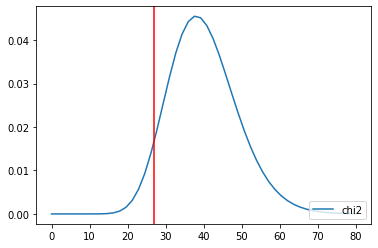

In [90]:
#Now lets look at our chi2 distribution and see how this compares
x = np.linspace(0,80)
chi2d=stats.chi2.pdf(x,40) # 40 bins
plt.plot(x,chi2d,label='chi2')
plt.axvline(result.chisqr, c='red')
plt.legend(loc='lower right')

Thats great! It's in the bump and not on the tails. If anything our uncertainties are too large. 

So did we get the right function? 

### Challenge Question: 

Repeat the above fit with a function: 
\begin{equation}
 f(x) = a x + b 
\end{equation}

What is the $\chi^{2}$? Which fit is better? 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 30
    # variables        = 2
    chi-square         = 29.8718324
    reduced chi-square = 1.06685116
    Akaike info crit   = 3.87155779
    Bayesian info crit = 6.67395255
[[Variables]]
    a:  1053.22719 +/- 6.95345272 (0.66%) (init = 1000)
    b:  1071.90427 +/- 6.17403788 (0.58%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.872


<Figure size 432x288 with 0 Axes>

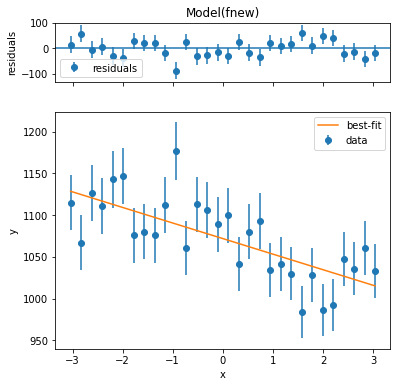

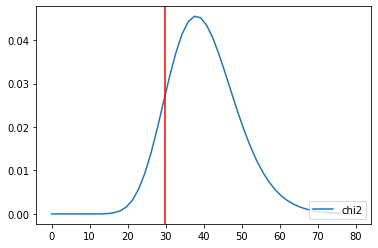

In [91]:
#answer
def fnew(x,a,b):
    pVal=b*(1-x)
    return a*x+pVal

label8='events_a8_1space.dat'
dec,ra8,az=load(label8)
x,y,xweights=prephist(ra8)

model  = lmfit.Model(fnew)
p = model.make_params(a=1000,b=10)
result = model.fit(data=y,x=x, params=p, weights=xweights)
lmfit.report_fit(result)
plt.figure()
result.plot()
plt.show()

#Now lets look at our chi2 distribution and see how this compares
x = np.linspace(0,80)
chi2d=stats.chi2.pdf(x,40) # 40 bins
plt.plot(x,chi2d,label='chi2')
plt.axvline(result.chisqr, c='red')
plt.legend(loc='lower right')
hide_toggle()

So the above makes it such that its not always clear what the best fit function is. Both have good $\chi^{2}$ values. One is better, but did we just fluctuate luckily in the right way? This is where physics, and for that matter knowledge of the data really comes into play. Which one is your favorite? 